# Covid-19 Data Analysis

Author: Gabriel (Alex) Palermo
Last Edit: 11-14-2020

## Introduction

The purpose of this project is to demonstrate the use of python for exploratory data analysis by pulling COVID-19 case data in the United States and correlating with local and state level ordinances. This will allow for a future analysis which will evaluate the effectiveness of the pandemic responses. The project is divided into 3 major steps: 

1) load and clean the two datasets

2) make visualizations to overlay the new case and death rate with a few major policies

3) correlate the new case and death rate with the implementation of various policy types. This will be done by calculating the average and standard deviation of the differences in new case / death numbers on the day of implementation and 14 days afterwards for any given policy. 

Clear old variables and import libraries

In [1]:
%reset -f
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd
import seaborn as sns
import datetime
import re
from IPython.display import clear_output

Load the dataset of new COVID-19 cases and deaths

In [2]:
df = pd.read_csv('https://query.data.world/s/jbgdegbanosfmgly7etz2gxqsbhflk')
df.head()

,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000,new_cases,new_deaths,new_cases_per_100_000,new_deaths_per_100_000,new_cases_7_day_rolling_avg,new_deaths_7_day_rolling_avg
0,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-22,18181.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-23,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-24,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-25,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-26,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


# Data cleaning and preprocessing

## Covid-19 Case Data

- Select columns of interest:

    - location_name 

    - state

    - date

    - new_cases_per_100_000

    - new_cases_7_day_rolling_avg

    - new_deaths_per_100_000

    - new_deaths_7_day_rolling_avg

    - total_population (to normalize the data when aggregating to the state level)

- Convert the 'date' column from string to datetime

- Rename some columns to be more concise

In [3]:
# columns of interest
case_data = df.loc[:, [
    "location_name", 
    "state",
    "date", 
    "new_cases_per_100_000", 
    "new_deaths_per_100_000",
    "total_population"
]]

# rename columns
case_data.rename(inplace=True, columns={
    "new_cases_per_100_000"  : "cases_capita",    
    "new_deaths_per_100_000" : "deaths_capita",
    "total_population"       : "pop"   
})

# convert 'date' column to datetime
case_data['date'] = pd.to_datetime(case_data['date'])

- The 7 day rolling averages in the original dataset are cumulative, not per capita like the case and death numbers. The county population is included in each record, making it easy to calculate the 7 day rolling average per 100,000. 

- Replace NaN with 0. On cursory inpsection, they appear in the first record for cases and deather per capits and the first week of the pandemic in the 7 day rolling averages. 

- For a presently unknown reason, there are some negative numbers reported under deaths_capita. These will be replaced with 0. 

- Perform a sanity check by displaying the first 5 and most recent 5 days for Orange County, California

In [4]:
# normalize the 7 day rolling averages (instead of cumulative #s convert to cases / deaths per 100,000)
case_data["cases_7day"]  = df.new_cases_7_day_rolling_avg /(df.total_population/1e5)
case_data["deaths_7day"] = df.new_deaths_7_day_rolling_avg/(df.total_population/1e5)

# replace any na values with 0
case_data.fillna(value=0, inplace=True)

# replace any negative values in case / death numbers with 0
cols = ["cases_capita", "deaths_capita", "cases_7day", "deaths_7day"]
case_data[cols] = case_data[cols].clip(lower=0)

# display the first and last few data entries to ensure that the numbers are sensible
print("Case data for Orange County, CA at the beginning of the pandemic:")
case_data[(case_data["state"] == "California") & (case_data["location_name"] == "Orange")].head(5)

Case data for Orange County, CA at the beginning of the pandemic:


,location_name,state,date,cases_capita,deaths_capita,pop,cases_7day,deaths_7day
87615,Orange,California,2020-01-22,0.00,0.0,3164182.0,0.0,0.0
87616,Orange,California,2020-01-23,0.00,0.0,3164182.0,0.0,0.0
87617,Orange,California,2020-01-24,0.00,0.0,3164182.0,0.0,0.0
87618,Orange,California,2020-01-25,0.00,0.0,3164182.0,0.0,0.0
87619,Orange,California,2020-01-26,0.03,0.0,3164182.0,0.0,0.0


In [5]:
print("Case data for Orange County, CA currently:")
case_data[(case_data["state"] == "California") & (case_data["location_name"] == "Orange")].tail(5)

Case data for Orange County, CA currently:


,location_name,state,date,cases_capita,deaths_capita,pop,cases_7day,deaths_7day
87907,Orange,California,2020-11-09,9.73,0.00,3164182.0,10.226024,0.112825
87908,Orange,California,2020-11-10,8.44,0.09,3164182.0,10.049991,0.126415
87909,Orange,California,2020-11-11,10.59,0.06,3164182.0,10.492443,0.103976
87910,Orange,California,2020-11-12,9.32,0.19,3164182.0,10.600844,0.117250
87911,Orange,California,2020-11-13,18.90,0.06,3164182.0,11.905447,0.085646


This data appears sensible, now to load and clean the policy data. 

## Covid - 19 Policy Data

Load a dataset which categorizes the various covid-19 responses throughout the country.

latest update: 11-14-2020

source: https://healthdata.gov/dataset/covid-19-state-and-county-policy-orders

In [6]:
df2 = pd.read_csv('state_policy_updates_20201114_0719.csv')
df2.head()

,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases
0,NY,Bronx,36005.0,county,2020-06-08,Non-Essential Businesses,start,"Policy_Details: Construction\r\nAgriculture, F...",sip_submission_form: https://coronavirus.healt...,NaN
1,DE,NaN,NaN,state,2020-03-27,Modify Medicaid Requirements With 1135 Waivers...,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
2,FL,NaN,NaN,state,2020-03-18,Allow Expand Medicaid Telehealth Coverage,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
3,MI,Delta,26041.0,county,2020-07-31,Entertainment,start,"Policy_Details: Region 8 indoor cinemas, conve...",sip_submission_form: https://www.michigan.gov/...,NaN
4,NE,Box Butte,31013.0,county,2020-03-30,Shelter in Place,start,http://dhhs.ne.gov/Pages/COVID-19-Directed-Hea...,manual,NaN


Select columns of interest

In [7]:
policy_data = df2.loc[:, [
    "state_id", 
    "county", 
    "policy_level", 
    "date", 
    "policy_type", 
    "start_stop", 
    "comments"
]]

List all policy types

In [8]:
print(np.sort((policy_data.policy_type.unique())))

['Agriculture' 'Allow Audio Only Telehealth'
 'Allow Expand Medicaid Telehealth Coverage'
 'Alternative Care Facilities ' 'Bars' 'Childcare (K-12)'
 'Colleges & Universities' 'Construction' 'Day Care'
 'Day camps/overnight camps' 'Education' 'Election' 'Entertainment'
 'Executive Order' 'Food and Drink' 'Froze Mortgage Payments' 'Gatherings'
 'Graduation' 'Graduation Ceremony guidelines' 'Gyms' 'Health Risk Status'
 'Houses of Worship'
 'Mandate Face Mask Use By All Individuals In Public Facing Businesses'
 'Mandate Face Mask Use By All Individuals In Public Spaces'
 'Manufacturing' 'Mask Requirement' 'Medical'
 'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'
 'New Phase' 'Non-Essential Businesses' 'Nursing Home Visitations'
 'Nursing Homes' 'Order Freezing Utility Shut Offs'
 'Outdoor and Recreation' 'Personal Care' 'Phase 1' 'Phase 2' 'Phase 2, 3'
 'Phase 3' 'Phase 3 Step 2' 'Phase 4' 'Phase 5' 'Public Gatherings'
 'Public Health Advisory System' 'Quarantine'
 '

Some of these policy names are very long, let's re-word all the ones that are longer than 40 characters.

In [9]:
long_names = [policy for policy in policy_data['policy_type'].unique() if len(policy)>40]
for i in long_names: 
    print(i)

Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval
Allow Expand Medicaid Telehealth Coverage
Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues
Mandate Face Mask Use By All Individuals In Public Spaces
Mandate Face Mask Use By All Individuals In Public Facing Businesses
Reopened ACA Enrollment Using a Special Enrollment Period
Suspended Elective Medical Dental Procedures
Stop Initiation Of Evictions Overall Or Due To Covid Related Issues
Renter Grace Period Or Use Of Security Deposit To Pay Rent


In [10]:
policy_replacements_dict = {
    'Stop Initiation Of Evictions Overall Or Due To Covid Related Issues': 'Stop Initiation Of Evictions',
    'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval': 'Modify Medicaid Requirements', 
    'Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues': 'Stop Enforcement Of Evictions', 
    'Mandate Face Mask Use By All Individuals In Public Facing Businesses':  'Mandate Face Masks In Businesses', 
    'Mandate Face Mask Use By All Individuals In Public Spaces': 'Mandate Face Masks In Public Spaces', 
    'Reopened ACA Enrollment Using a Special Enrollment Period': 'ACA Special Enrollment Period', 
    'Suspended Elective Medical Dental Procedures': 'Suspend Elective Dental Procedures', 
    'Allow Expand Medicaid Telehealth Coverage': 'Expand Medicaid Telehealth Coverage', 
    'Renter Grace Period Or Use Of Security Deposit To Pay Rent': 'Grace Period / Security Deposit for Rent'
}

for key in policy_replacements_dict.keys():
    policy_data['policy_type'].replace(to_replace=key, value=policy_replacements_dict[key], inplace=True)
    
long_names = [policy for policy in policy_data['policy_type'].unique() if len(policy)>40]
if len(long_names) == 0: 
    print("no more long names")

no more long names


- change NaNs in "county" to say "statewide"

- convert date field to datetime

- convert all policy names to lowercase (notice that both "construction" and "Construction" are listed)

- drop non-specific policies (i.e. phase #)

- There are some differences in county names between the case dataset and the policy dataset. For example, Haines Borough in the policy dataset is written simply as "Haines" in the case dataset. There are 4 of these discrepancies for a number of different counties. Simply strip the offending word off the end of the county name in the policy dataset so it matches in the case dataset. 

In [11]:
# Change NaNs in "county" to "statewide"
policy_data['county'].fillna(value="statewide", inplace=True)

# Change date field to datetime
policy_data['date'] = pd.to_datetime(policy_data['date'])

# convert policy_types to lowercase
policy_data['policy_type'] = policy_data['policy_type'].str.lower()

# drop any policies that may have been implemented before the start of the case dataset
start_date = min(case_data['date'])
policy_data.drop(policy_data[policy_data['date'] < start_date].index, inplace=True)

# drop non-specific policies
policies_drop = ["phase 1", "phase 2", "phase 3", "phase 4", "phase 5", "new phase"]
policy_data = policy_data.drop(policy_data[policy_data['policy_type'].isin(policies_drop)].index)

# If the name of a county ends in "County", "Municipality", "City", or "Borough" in the policy dataset we're going to strip
# it so it matches with the case dataset
county_match    = re.compile(" County$")
munici_match    = re.compile(" Municipality$")
city_match      = re.compile(" city$")
Borough_match   = re.compile(" Borough$")

policy_data['county'].replace(to_replace= county_match, value='', inplace=True)
policy_data['county'].replace(to_replace= munici_match, value='', inplace=True)
policy_data['county'].replace(to_replace=   city_match, value='', inplace=True)
policy_data['county'].replace(to_replace=Borough_match, value='', inplace=True)


In [12]:
print(np.sort((policy_data.policy_type.unique())))

['aca special enrollment period' 'agriculture'
 'allow audio only telehealth' 'alternative care facilities ' 'bars'
 'childcare (k-12)' 'colleges & universities' 'construction'
 'day camps/overnight camps' 'day care' 'education' 'election'
 'entertainment' 'executive order' 'expand medicaid telehealth coverage'
 'food and drink' 'froze mortgage payments' 'gatherings'
 'grace period / security deposit for rent' 'graduation'
 'graduation ceremony guidelines' 'gyms' 'health risk status'
 'higher education' 'houses of worship' 'libraries'
 'mandate face masks in businesses' 'mandate face masks in public spaces'
 'manufacturing' 'mask requirement' 'medical'
 'modify medicaid requirements' 'museums' 'non-essential businesses'
 'nursing home visitations' 'nursing homes'
 'order freezing utility shut offs' 'outdoor and recreation'
 'personal care' 'phase 2, 3' 'phase 3 step 2' 'public gatherings'
 'public health advisory system' 'quarantine'
 'residential overnight camps' 'resumed elective med

This dataset uses state ids instead of full state names. There is a prewritten dictionary here which converts from state abbreviation to full state names: 
https://gist.github.com/rogerallen/1583593#file-us_state_abbrev-py

- Import the us state abbreviations dictionary and check that it works

- Remove US territories so only the 50 states are represented

In [13]:
direct = %pwd
%run $direct\\us_state_abbrev.py
print(f"testing: abbreviation for California is {us_state_abbrev['California']}")
      
# Remove the 5 US territories since we're limiting ourselves to the 50 states
us_state_abbrev.pop('American Samoa');
us_state_abbrev.pop('Guam');
us_state_abbrev.pop('Northern Mariana Islands');
us_state_abbrev.pop('Virgin Islands');
us_state_abbrev.pop('Puerto Rico');
      
abbrev_us_state.pop('AS');
abbrev_us_state.pop('GU');
abbrev_us_state.pop('MP');
abbrev_us_state.pop('VI');
abbrev_us_state.pop('PR');

Wisconsin --> WI? True
WI --> Wisconsin? True
Number of entries (50 states, DC, 5 Territories) == 56?  True
testing: abbreviation for California is CA


In [14]:
# Drop territories from both datasets

case_data = case_data.drop(case_data[~case_data['state'].isin(us_state_abbrev)].index)
policy_data = policy_data.drop(policy_data[~policy_data['state_id'].isin(abbrev_us_state)].index)

# Data visualization

Write a few functions that will filter data for a specific county and state and generate a plot. Aditionally, create a visualization that overlays some selected policies over the case and death data. 

In [15]:
def get_cases(level="county", county="Orange", state="California", df=case_data):
    
    """ A function which filters case_data to a specific county. 
    inputs:  
    level  -- "county" [default] - get county level data
              any other input - get state level data
    county -- desired county
    state  -- desired state
    df     -- DataFrame to use, case_data by default
    
    return: 
    dataFrame -- case_data filtered to a specific county with index=date
    """
    
    if level == "county":
        return  df[(df["location_name"] == county) & (df["state"] == state)].set_index("date")
    
    else: 
        # filter data to desired state
        df = df[df['state'] == state]

        # reindex on location name
        df = df.set_index(["location_name"])

        # get a list of all dates
        all_dates = pd.to_datetime(np.unique(df['date'].to_numpy()))

        # get the state population from county populations
        pop =  sum([(pops/1e5) for pops in df[df['date']==all_dates[0]]['pop']]) 

        # add up the case and death #s that have the same date and state (adding cover counties)
        state_cases       = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['cases_capita' ]]) 
                           for dates in all_dates]

        state_deaths      = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['deaths_capita']]) 
                           for dates in all_dates]

        state_cases_7day  = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['cases_7day'   ]]) 
                           for dates in all_dates]

        state_deaths_7day = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['deaths_7day'  ]]) 
                           for dates in all_dates]
        
        return pd.DataFrame(data={'date'    : all_dates,
                            'cases_capita'  : state_cases, 
                            'deaths_capita' : state_deaths,
                            'cases_7day'    : state_cases_7day,
                            'deaths_7day'   : state_deaths_7day
                            }).set_index(["date"])

Test the get_cases function on the county and state level

In [16]:
get_cases(level="county", county="Mecklenburg", state="North Carolina").tail()

,location_name,state,cases_capita,deaths_capita,pop,cases_7day,deaths_7day
date,,,,,,,
2020-11-09,Mecklenburg,North Carolina,14.51,0.38,1054314.0,21.584651,0.176418
2020-11-10,Mecklenburg,North Carolina,36.04,0.00,1054314.0,23.955861,0.148912
2020-11-11,Mecklenburg,North Carolina,30.16,0.09,1054314.0,24.009925,0.135633
2020-11-12,Mecklenburg,North Carolina,22.48,0.19,1054314.0,24.253685,0.135633
2020-11-13,Mecklenburg,North Carolina,21.63,0.00,1054314.0,24.145558,0.122354


In [17]:
get_cases(level="state", state="North Carolina").tail()

,cases_capita,deaths_capita,cases_7day,deaths_7day
date,,,,
2020-11-09,14.786782,0.027374,23.786033,0.510355
2020-11-10,23.901239,0.448028,23.692972,0.390214
2020-11-11,27.288033,0.435030,24.237861,0.343372
2020-11-12,26.437273,0.034070,23.844530,0.247106
2020-11-13,17.890087,0.290381,22.368135,0.223883


In [18]:
def plot_cases(level="county", county="Orange", state="California", df=case_data,
              fade=0.75):
    
    """ A function which plots the COVID-19 case/death data and 7 day average
    inputs: 
    level  -- "county" [default] - plot county level data
              any other input - plot state level data
    county -- desired county
    state  -- desired state
    df     -- DataFrame to use, case_data by default
    
    return: 
    [fig, ax] -- figure and axis handles, respectively, for the generated plot
    """
    
    # get the data
    cases = get_cases(level, county, state, df)
        
    # plot the data
    fig, ax = plt.subplots(2, 1, figsize=(12,10), sharex=True);
    plt.subplots_adjust(hspace=0.02)
    sns.set_style("whitegrid")
    
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["cases_capita","cases_7day"],
        label=["Cases per capita", "7-day average"],
        ax=ax[0]
    );

    
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["deaths_capita","deaths_7day"],
        label=["Deaths per capita", "7-day average"],
        ax=ax[1]
    );
    
    # format and title axes
    fig.autofmt_xdate()
    ax[0].set_ylabel("cases per 100,000")
    ax[1].set_ylabel("deaths per 100,000")
    
    
    if level == "county":
        ax[0].set_title(f"Covid-19 cases and deaths per 100,000 in {county} County, {state}");
        
    else: 
        ax[0].set_title(f"Covid-19 cases and deaths per 100,000 in {state}");
    
    
    
    return fig, ax, cases

test the plot function

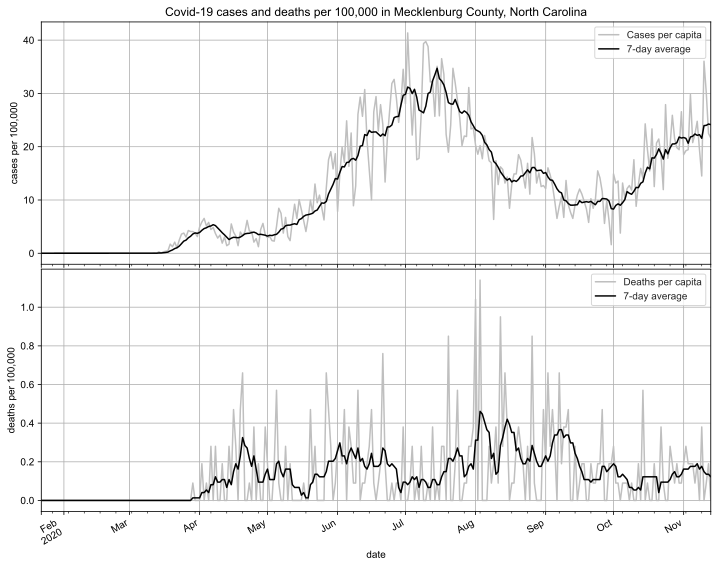

In [19]:
plot_cases(level="county", county="Mecklenburg", state="North Carolina");

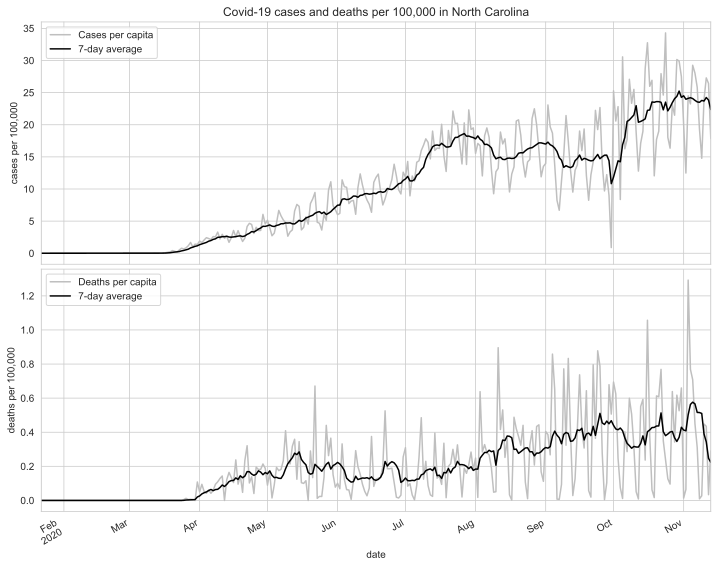

In [20]:
plot_cases(level="state", state="North Carolina");

Get and filter the policy data to return the policies for a specific state and/or county at the state level, county level, or both. 

In [21]:
def get_policy_data(state="California", county="statewide", state_policies=True, county_policies=True, df=policy_data):
    """A function which returns the policy data at either the state level, county level, or both
    inputs: 
    state -- selected state
    county -- selected county
    state_policies -- include policies at the state level
    county_policies -- include policies at the county level
    
    return: 
    filtered DataFrame
    """
    
    state_abbrev = us_state_abbrev[state]

    if state_policies and county_policies:

        policies_filtered = df[

            (df['state_id'] == state_abbrev) &

            ((df["county"].str.contains(county))  
            | (df["county"].str.contains("statewide"))) 

        ]

    elif state_policies and not county_policies: 
        policies_filtered = df[

            (df['state_id'] == state_abbrev) &
  
            (df["county"].str.contains("statewide")) 
        ]
    elif not state_policies and county_policies: 
        policies_filtered = df[

            (df['state_id'] == state_abbrev) &

            (df["county"].str.contains(county))
        ]
        
    return policies_filtered.loc[:, [
        "state_id", 
        "county", 
        "policy_level", 
        "date", 
        "policy_type", 
        "start_stop"
    ]]

Test the filter policy function for Mecklenburg County, NC

In [22]:
get_policy_data(county="Mecklenburg", state="North Carolina").head(19)

,state_id,county,policy_level,date,policy_type,start_stop
375,NC,statewide,state,2020-10-02,non-essential businesses,stop
567,NC,statewide,state,2020-05-08,personal care,start
603,NC,statewide,state,2020-05-08,food and drink,start
619,NC,Mecklenburg,county,2020-03-26,shelter in place,start
654,NC,statewide,state,2020-06-26,mask requirement,start
928,NC,statewide,state,2020-03-23,expand medicaid telehealth coverage,start
945,NC,statewide,state,2020-03-23,nursing homes,start
995,NC,statewide,state,2020-03-23,modify medicaid requirements,start
1081,NC,statewide,state,2020-05-08,day care,start
1107,NC,statewide,state,2020-05-22,houses of worship,start


### Visualization of selected Covid-19 responses

Plot some selected policies over new cases and new deaths

Selected policies: 
- mandate face mask use by all individuals in public spaces
- mandate face mask use by all individuals in public facing businesses
- shelter in place
- state of emergency

In [23]:
def plot_case_and_policies(county, state, colors=['k', 'b', 'r', 'g'],  
    policies=[
        "mandate face masks in public spaces", 
        "mandate face masks in businesses", 
        "shelter in place", 
        "state of emergency"],
                           
    labels=["face mask mandate (public spaces)", 
         "face mask mandate (businesses)", 
         "shelter in place", 
         "state of emergency"], 
    fade=0.75):

    
    """Plot the cases overlayed with the policies. 
    inputs: 
    county -- county of interest
    state  -- state of interest
    policies -- policies to plot
    colors   -- line colors for respective policies (in order)
    labels   -- legend labels for the selected policies
    
    The marks for policies are plotted on the 7 day average, using multiple colors in the case of multiple policies
    in the same day, and using horizontle lines (like an errorbar) if it is a state policy and solid dots if it's a 
    county policy
    """
    plt.figure();
    sns.set_style("whitegrid")
    fig, ax, df = plot_cases(level="county", county=county, state=state, fade=fade);
    

    # get the policy data for the selected state and county 
    policy_data = get_policy_data(state, county);

    # set a solid line to be the start of a policy and a dashed line to be the end
    styles_start_stop = {
        "start": '-', 
        "stop": ':'
    }

    # set color codes for selected policies
    styles_policy_type = {policies[i]: colors[i] for i in range(len(policies))}
    
    # set labels for legend
    legend_policy_labels = {policies[i]: labels[i] for i in range(len(policies))}

    legend_position=(1, 1)
    line_split = 0
    mark_length = 0.2
    plot_policies = policy_data[policy_data['policy_type'].isin(policies)]

    labels = []
    
    # loop through policies and axes
    for i in range(2):
        ax[i].set_ylim(-max(ax[i].lines[0].get_ydata())*(0.15))
        for index, row in plot_policies.sort_values(by="date").iterrows():

            # get the y-positional coordinate for the line on the selected day (between 0 and 1) 
            if i == 0: 
                center = df[df.index == row.date]['cases_7day'].values[0]
            else: 
                center = df[df.index == row.date]['deaths_7day'].values[0]
                
            days_serial = (row.date - pd.Timestamp(year=1970, month=1, day=1)).days
            cent_coord = ax[i].transLimits.transform((days_serial, center))[1]

            # loop through all the policies enacted on a given day. Normally, this is 1- but we want to visualize all the
            # policies enacted on the same day, so we're goint to split the line accordingly 

            num_policies = plot_policies['date'].value_counts()[row.date]

            if num_policies > 1: 
                hmin = (cent_coord-mark_length/2) + line_split * (mark_length/num_policies)
                hmax = (cent_coord+mark_length/2) - \
                    (mark_length/num_policies) + ((line_split*mark_length)/num_policies)
                line_split += 1

            if num_policies == 1:
                hmin = (cent_coord-mark_length/2)
                hmax = (cent_coord+mark_length/2)
                line_split=0
            line = ax[i].axvline(x=row.date,
                                 linestyle = styles_start_stop[row.start_stop], 
                                 color     = styles_policy_type[row.policy_type], 
                                 lw        = 2,
                                 ymin      = hmin, 
                                 ymax      = hmax)

            #label=f"{row.start_stop} {legend_policy_labels[row.policy_type]}"
            if (row.policy_type not in labels): 
                labels.append(row.policy_type);
            if row.policy_level == "state":
                line.set_marker('d')
            else: 
                line.set_marker('o')
            ax[i].legend(loc = "upper left")
        
    # make legend
    legend_lines = []
    [legend_lines.append(Line2D([0], [0], marker="s", markersize=15, color='w', 
                           markerfacecolor=styles_policy_type[policy], lw=3, label=policy)) for policy in labels]
    
    legend_lines.append(Line2D([0], [0], marker="d", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label = "state policy"))
    
    legend_lines.append(Line2D([0], [0], marker="o", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label = "county policy"))
    
    legend_lines.append(Line2D([0], [0], linestyle='-', color='k', lw=3, label = "policy start"))
    legend_lines.append(Line2D([0], [0], linestyle=':', color='k', lw=3, label = "policy stop"))
                   
     
    
    leg1 = ax[0].legend(loc='upper left')
    leg2 = ax[0].legend(handles=legend_lines, bbox_to_anchor=legend_position)
    ax[0].add_artist(leg1)
            

<Figure size 432x288 with 0 Axes>

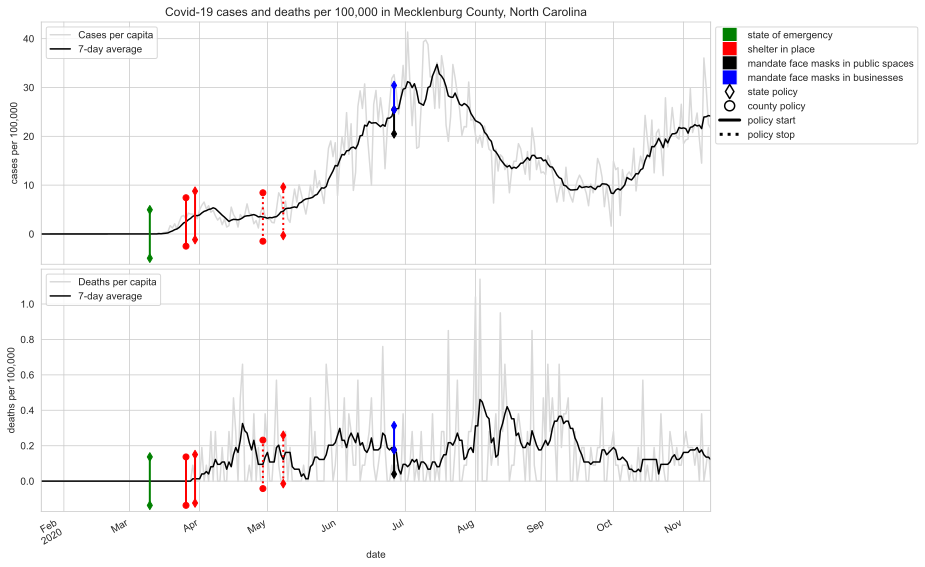

In [24]:
plot_case_and_policies("Mecklenburg", "North Carolina", fade=0.85);

<Figure size 432x288 with 0 Axes>

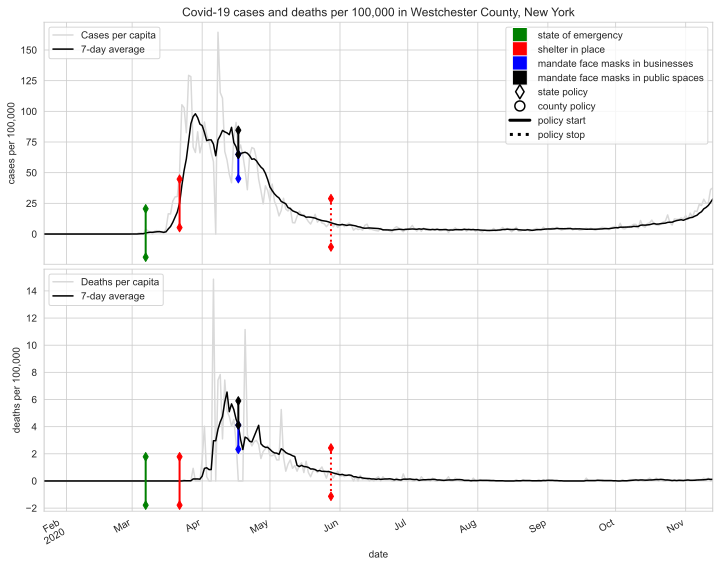

In [25]:
plot_case_and_policies("Westchester", "New York", fade=0.85);

# Find the correlation between change in cases and enactment of policies 

Correlate COVID-19 responses at the state and local level with the number of new cases and deaths at a variable time (14 days by default). This will use the 7 day average at the date in question to avoid outliers.

In [26]:
def calculate_deltas(measure_period=14, filtered_policies=None, df=policy_data):
    """For every policy implementation at the state and county level, calculate the change in case and death numbers. 
    inputs: 
    measure_period    -- time to wait
    min_samples       -- minimum number of samples
    filtered_policies -- selected policies to select
    
    returns: 
    A copy of the df (covid policies) dataframe with 2 appended columns for the change in case and death numbers. 
    """
    
    # initialize wait period before measurement
    wait_period = datetime.timedelta(days=measure_period) # time in days to watch change in case / death number
    day_1 = datetime.timedelta(days=1)
    
    # filter policies if needed and make a 2 copies of the original policies dataframe- one for iteration and another 
    # for modification
    
    if filtered_policies is not None: 
        all_policies  = df.loc[df['policy_type'].isin(filtered_policies)]
        policy_deltas = df.loc[df['policy_type'].isin(filtered_policies)]
    else: 
        all_policies  = df.copy()
        policy_deltas = df.copy()
    
    # initially fill the delta column with nan
    policy_deltas.loc[:, f"case_{measure_period}_day_delta"] = np.nan
    policy_deltas.loc[:, f"case_{measure_period}_day_accel"] = np.nan
    policy_deltas.loc[:, f"death_{measure_period}_day_delta"] = np.nan
    policy_deltas.loc[:, f"death_{measure_period}_day_accel"] = np.nan
    
    i=0 # counter to time the loop
    state_cases_dict = dict()

    # load all state-aggregated datasets into a dictionary
    print("aggregating state data")
    for state in us_state_abbrev: 
        state_cases_dict[state]=get_cases(level="state", state=state)
    
    print("aggregating state data complete")
        
    # loop through all policies in the policy dataset
    for index, data in all_policies.iterrows(): 

        # handle state info
        if data.policy_level == "state": 
            policy_case_df = state_cases_dict[abbrev_us_state[data.state_id]]

        # handle county info
        else: 
            policy_case_df = get_cases(level="county", county=data.county, state=abbrev_us_state[data.state_id])

        # output status updates since this loop takes a long time (~3 minutes)
        i += 1
        if i%100 == 0: 
            print(f"record {i}/{len(all_policies.index)}")
        policy_date = pd.to_datetime(data['date'])
        measure_date = policy_date + wait_period
        
        # pass if the measure date is within 3 days (gives the case data time to update)
        if measure_date > pd.Timestamp.today() - datetime.timedelta(days=3): 
            continue
        
        # calculate "velocity" of covid cases
        cases_start  = policy_case_df[policy_case_df.index==policy_date ]['cases_7day' ].values
        cases_end    = policy_case_df[policy_case_df.index==measure_date]['cases_7day' ].values
        deaths_start = policy_case_df[policy_case_df.index==policy_date ]['deaths_7day'].values
        deaths_end   = policy_case_df[policy_case_df.index==measure_date]['deaths_7day'].values

        delta_cases  = cases_end  - cases_start
        delta_deaths = deaths_end - deaths_start
        
        policy_deltas.at[index, f"case_{measure_period}_day_delta"]  = delta_cases
        policy_deltas.at[index, f"death_{measure_period}_day_delta"] = delta_deaths
        
        # calculate "acceleration" of covid cases
        # (velocity at end of measure period - velocity at start) / measure period 
        c11 = policy_case_df[policy_case_df.index==measure_date       ]['cases_7day' ].values
        c12 = policy_case_df[policy_case_df.index==measure_date+day_1 ]['cases_7day' ].values
        
        c21 = policy_case_df[policy_case_df.index==policy_date        ]['cases_7day' ].values
        c22 = policy_case_df[policy_case_df.index==policy_date+day_1  ]['cases_7day' ].values
        
        d11 = policy_case_df[policy_case_df.index==measure_date       ]['deaths_7day'].values
        d12 = policy_case_df[policy_case_df.index==measure_date+day_1 ]['deaths_7day'].values
        
        d21 = policy_case_df[policy_case_df.index==policy_date        ]['deaths_7day'].values
        d22 = policy_case_df[policy_case_df.index==policy_date+day_1  ]['deaths_7day'].values
        
        case_accel   = ((c12-c11) - (c21-c22)) / measure_period
        deaths_accel = ((d12-d11) - (d21-d22)) / measure_period
        
        policy_deltas.at[index, f"case_{measure_period}_day_accel"]  = case_accel
        policy_deltas.at[index, f"death_{measure_period}_day_accel"] = deaths_accel
        
    clear_output()
    return policy_deltas

In [27]:
def delta_stats(deltas, measure_period=14, min_samples=10):
    """Take the deltas calculated with each policy and calculate the average and sd. 
    inputs: 
    deltas         -- dataframe of policy deltas on which to do the calculations
    measure_period -- how long to wait before measuring the effect of the policy
    min_samples    -- minimum number of samples that a policy must have for reporting of average and std
    
    returns: 
    A dataframe with a record for the start/stop of each policy type and the average / std of the change in 
    case / death numbers measure_period days after implementation
    """

    # generate a new list of policy types differentiating between start and stop 
    
    policy_types = ([elem+" - start" for elem in deltas['policy_type'].unique()] + 
                    [elem+" - stop"  for elem in deltas['policy_type'].unique()])
    
    case_avg, death_avg, case_std, death_std, num_samples = [], [], [], [], []
    case_accel_avg, death_accel_avg, case_accel_std, death_accel_std = [], [], [], []
    
    for policy in policy_types:
        if policy.endswith("stop"):
            len_index = -7
            start_stop = "stop"
        else: 
            len_index = -8
            start_stop = "start"
            
        case_data  = deltas[(deltas['policy_type']==policy[:len_index]) & 
                            (deltas['start_stop']==start_stop)][f'case_{measure_period}_day_delta']

        death_data = deltas[(deltas['policy_type']==policy[:len_index]) & 
                            (deltas['start_stop']==start_stop)][f'death_{measure_period}_day_delta']

        case_accel_data = deltas[(deltas['policy_type']==policy[:len_index]) & 
                            (deltas['start_stop']==start_stop)][f'case_{measure_period}_day_accel']
        
        death_accel_data = deltas[(deltas['policy_type']==policy[:len_index]) & 
                            (deltas['start_stop']==start_stop)][f'death_{measure_period}_day_accel']

        num_samples.append(len(case_data))

        case_avg.append(np.nanmean(case_data.to_numpy()))
        death_avg.append(np.nanmean(death_data.to_numpy()))
            
        case_std.append(np.nanstd(case_data.to_numpy()))
        death_std.append(np.nanstd(death_data.to_numpy()))
        
        case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
        death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))
        
        case_accel_std.append(np.nanstd(case_accel_data.to_numpy()))
        death_accel_std.append(np.nanstd(death_accel_data.to_numpy()))
        
        
        
    # construct the dataframe to tabulate the data
    delta_stats = pd.DataFrame(np.transpose([case_avg, case_accel_avg, death_avg, death_accel_avg, 
                                             case_std, case_accel_std, death_std, death_accel_std, 
                                             num_samples]), index = policy_types, 
                               columns=['case_avg', 'case_accel_avg', 'death_avg', 'death_accel_avg', 
                                        'case_std', 'case_accel_std', 'death_std', 'death_accel_std', 
                                        'num_samples']
                              )

    # drop record with less than 10 samples
    delta_stats.drop(delta_stats[delta_stats['num_samples']<=min_samples].index, inplace=True)
    return delta_stats

Run each function to calculate the average and standard deviation of the change in cases and deaths. 

In [28]:
policy_deltas = calculate_deltas()
policy_deltas.head()

,state_id,county,policy_level,date,policy_type,start_stop,comments,case_14_day_delta,case_14_day_accel,death_14_day_delta,death_14_day_accel
0,NY,Bronx,county,2020-06-08,non-essential businesses,start,"Policy_Details: Construction\r\nAgriculture, F...",-2.443889,-0.024838,-0.457621,0.000745
1,DE,statewide,state,2020-03-27,modify medicaid requirements,start,Other measures and details for this policy inc...,3.739756,0.040141,0.016256,0.006992
2,FL,statewide,state,2020-03-18,expand medicaid telehealth coverage,start,Other measures and details for this policy inc...,0.537028,0.011618,0.013632,0.000377
3,MI,Delta,county,2020-07-31,entertainment,start,"Policy_Details: Region 8 indoor cinemas, conve...",2.348715,0.112501,0.000000,0.000000
4,NE,Box Butte,county,2020-03-30,shelter in place,start,http://dhhs.ne.gov/Pages/COVID-19-Directed-Hea...,1.262512,0.000000,0.000000,0.000000


In [29]:
deltas = delta_stats(deltas=policy_deltas)
deltas.head()

<ipython-input-27-dd3eb1eee9a0>:43: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-27-dd3eb1eee9a0>:44: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-27-dd3eb1eee9a0>:49: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-27-dd3eb1eee9a0>:50: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


,case_avg,case_accel_avg,death_avg,death_accel_avg,case_std,case_accel_std,death_std,death_accel_std,num_samples
non-essential businesses - start,3.728849,0.097935,-0.039154,-0.000613,13.966740,0.636631,0.472290,0.023592,139.0
modify medicaid requirements - start,3.399588,0.021065,0.131278,0.001436,4.634017,0.046262,0.255130,0.003367,51.0
expand medicaid telehealth coverage - start,2.529374,0.018308,0.105467,0.001117,2.727977,0.049735,0.213844,0.003932,50.0
entertainment - start,2.853639,-0.003776,-0.027280,-0.001296,12.304829,0.245671,0.507118,0.025733,123.0
shelter in place - start,2.810309,0.025071,0.087821,0.001296,7.995983,0.180364,0.248152,0.006067,456.0


The "Mean of empty slice" warnings may be safely ignored- these correspond to policies for no counties / states have implemented (e.g. stopping policies related to "allow audio only telehealth")

## Connecting the start/stop of a policy and case/death numbers

Let's explore how these numbers look by examining what is associated with the most extreme changes in each of the 4 metrics (i.e. largest increase / decrease in the average / acceleration of new cases / deaths). 

What should we expect? 

During the beginning of the first wave, state and local governemnts issued a flurry of ordinances aimed at slowing down the spread of the pandemic. Since many policies were started before the peak of the first wave, it's likely that we'll see the start of many policies correlated with an increase in average number of new cases coupled with a decrease in the acceleration of new cases. 

Policies are typically stopped when cases are declining, so we might expect that stopping a policy might be correlated with a decrease in the average number of cases. However, stopping a policy may also cause more spreading, especially if people aren't following basic guidelines. This means that stopping a policy might be correlated with an increase in the acceleration of new cases. 

Deaths are a little harder to judge. These datapoints for increase in average and acceleration were taken for a 2 week period. Since death numbers typically lag case numbers, it's ambiguous as to how much correlation between the start/stop of a policy would appear in this dataset. 

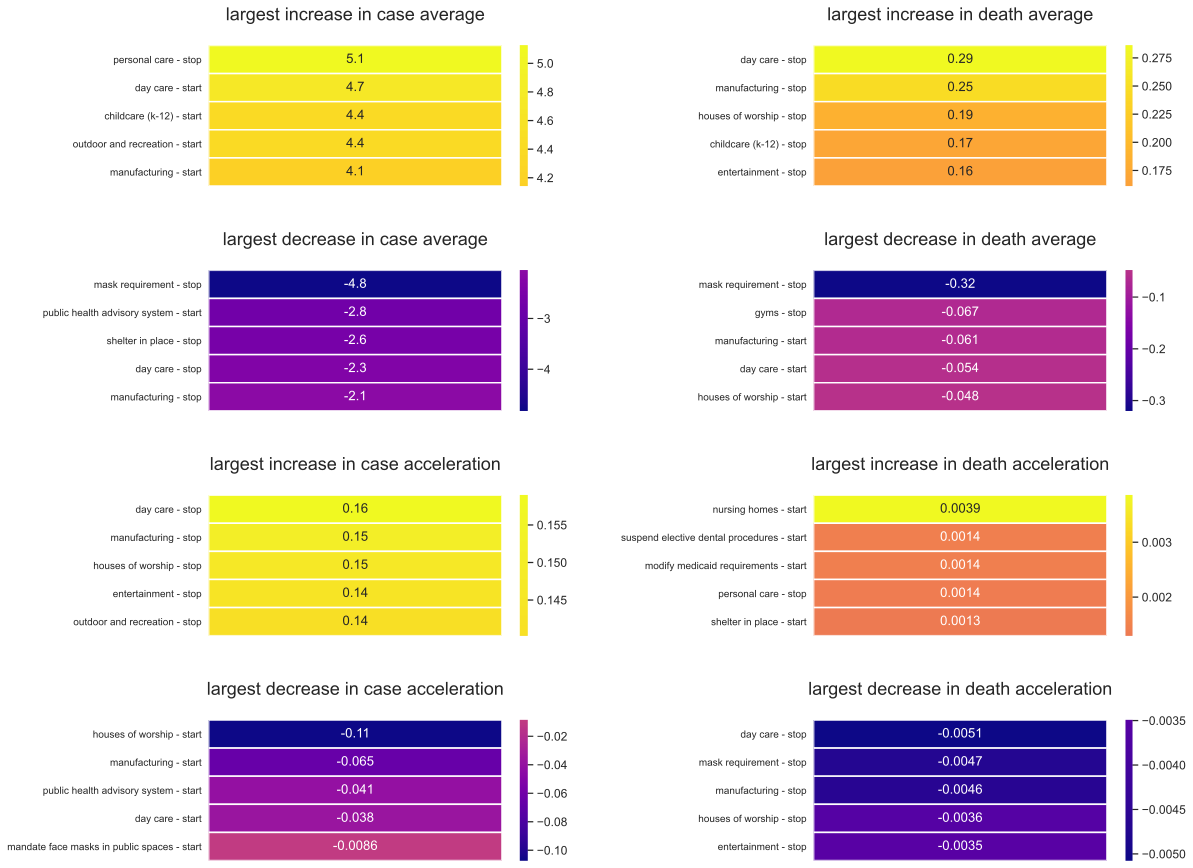

In [30]:
dfs_case = [deltas.sort_values(by="case_avg", ascending=False)[["case_avg"]].head(),
       deltas.sort_values(by="case_avg", ascending=True)["case_avg"].head(), 
       deltas.sort_values(by="case_accel_avg", ascending=False)["case_accel_avg"].head(),
       deltas.sort_values(by="case_accel_avg", ascending=True)["case_accel_avg"].head()]

dfs_death = [deltas.sort_values(by="death_avg", ascending=False)["death_avg"].head(),
       deltas.sort_values(by="death_avg", ascending=True)["death_avg"].head(), 
       deltas.sort_values(by="death_accel_avg", ascending=False)["death_accel_avg"].head(),
       deltas.sort_values(by="death_accel_avg", ascending=True)["death_accel_avg"].head()]


titles_case = [
    "largest increase in case average\n",
    "largest decrease in case average\n",
    "largest increase in case acceleration\n",
    "largest decrease in case acceleration\n", 
]

titles_death = [
    "largest increase in death average\n", 
    "largest decrease in death average\n", 
    "largest increase in death acceleration\n", 
    "largest decrease in death acceleration\n"
]

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[15, 15])
plt.subplots_adjust(hspace=0.6, wspace=0.65, left=0)
sns.set(font_scale=1.1)
#fig.tight_layout()
for i in range(len(ax[:,0])): 
        handles = sns.heatmap(np.asarray(dfs_case[i]).reshape(5,1), 
                              yticklabels=dfs_case[i].index, 
                              xticklabels="",
                              ax=ax[i,0], 
                              cbar=True, 
                              annot=True, 
                              cmap="plasma",
                              center = 0, 
                              linewidths=1.5
                             )
        ax[i,0].set_title(titles_case[i], fontsize=18)
        
        handles = sns.heatmap(np.asarray(dfs_death[i]).reshape(5,1), 
                              yticklabels=dfs_death[i].index,
                              xticklabels="", 
                              ax=ax[i,1], 
                              cbar=True, 
                              annot=True, 
                              cmap="plasma", 
                              center = 0,
                              linewidths=1.5
                             )
        ax[i,1].set_title(titles_death[i], fontsize=18)

In each heatmap, 4/5 of the policies are either all stop or all start. The results are summarized here: 

|              |           start              |            stop              |
| :----------: | :--------------------------: | :--------------------------: |
| **increase** | case avg, death acceleration | death avg, case acceleration | 
| **decrease** | death avg, case acceleration | case avg, death acceleration |


Looking back at the earlier predictions, this is exactly what we expected! starting a policy is correlated with an increase in average number of cases but decrease in acceleration, and vice versa for the start of a policy. 

What's even more interesting is that the death metrics. They appear to be the exact opposite of cases. I'll have to save an interpretation on this for later iterations of this project, as it might be wise to investigate these trends with several different time frames. 

It is imporant to remember that correlation =/= causation. Even though closing houses of worship is correlated with the largest decrease in case acceleration, that does not mean that closing houses of worship CAUSED the largest decrease in case acceleration. There are many, many variables involved. Some of them we can control- such as multiple policies being implemented within a short timespan, and specific details of a policy implementation\*; however, there are many others that we cannot control- such public compliance and advancments in treatment, which are out of the scope of this project. 

To control for the implementation of multiple policies, a linear regression algorithm might be able to help, as described in the next section. 

\*The COVID-19 policies dataset includes a field for comments which has more details of the implementation. This may be the subject of a future text-mining project to examine specific policies in a more granular fashion. 

## Linear regression

Here we try to understand which policies have the largest respective contributions to the acceleration of case and death rates. For a first shot at this model, I would like to consider using this equation: 

$$c(d) = \sum_{all policies} P_{i} \omega_{i}f(\delta d)$$

Where: 
- $c(d)$ = the case or death rate acceleration on a specified day $d$
- $P_{i}$ is 1 if the policy was enacted in the county or state $\delta d$ days before the date of interest, 0 if not
- $\omega_{i}$ = the impact weight of an enacted policy
- $f(\delta d)$ = the time weight- a function that accounts for the time delay between policy enactment and change in cases. This should be a minimum 1 day after policy enactment and increases until the "golden zone" where the policy is most effective. 

Implementation of this model is still a work in progress. This project will be further updated with the implementation

# Conclusion and future work


To summarize, we cleaned 2 datasets: one on the covid-19 case and death numbers and another on the policy data. We plotted the case data at the country and state level and correlated those with policy implementations. Finally, we more elegantly correlated the policies with case data by aggregating all the policy implementations to get a measure on the change in cases and deaths, as well as how fast those case and death numbers are changing (acceleration). 

The next logical steps to this project require some more advanced data science tools: mainly text mining and machine learning, which for the sake of time I will have to revisit in a future version of this project. 

The following features are planned for the next iteration(s) of this project: 
- linear regression to un-couple multiple policy implementations
- text mining on the comments field in the policy dataset to characterize the correlation in more granular detail
- geospatial heatmap of current case and death figures

updates needed: 
- ensure that the policy and case / death number overlay works when 3+ policies are implemented on the same day 
- when plotting select counties, matplotlib is placing the legend with the policy info over the plot, not outside. Need to find a way to fix this